In [1]:
%pylab
%matplotlib inline

import os
import sys
import numpy    as np
import pandas   as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.metrics.pairwise  import euclidean_distances

from sklearn.cluster           import KMeans
from sklearn.metrics           import silhouette_score
from IPython.display           import Image
from sklearn.metrics.pairwise  import euclidean_distances

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [3]:
# Cargamos lo datos
data = pd.read_csv('walmart_new.csv', sep = ',')
df = data[data['Date'] > '2011-12-31']
df = df.loc[:, ['Store', 'TotalSalesWeek']]

df2 = df.groupby(by = ['Store']).mean().reset_index()
df2.head()

,Store,TotalSalesWeek
0,1,1.586113e+06
1,2,1.895274e+06
2,3,4.191744e+05
3,4,2.157479e+06
4,5,3.295087e+05


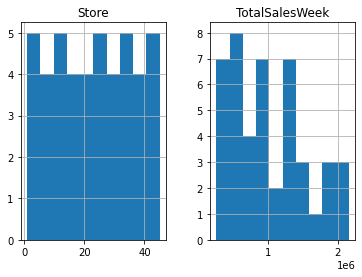

In [4]:
df2.hist()
plt.show()

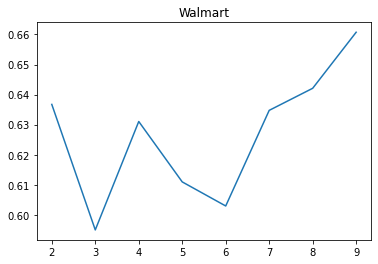

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

def plot_sillhouette(dataset, figure_name, max_k = 10, n_init = 10):
    sillhouette_avgs = []
    
    for k in range(2, max_k):
        kmean = KMeans(n_clusters = k, n_init = n_init).fit(dataset)
        sillhouette_avgs.append(silhouette_score(dataset, kmean.labels_))
        
    plot(range(2, max_k), sillhouette_avgs)
    title(figure_name)
    
plot_sillhouette(df2, 'Walmart')

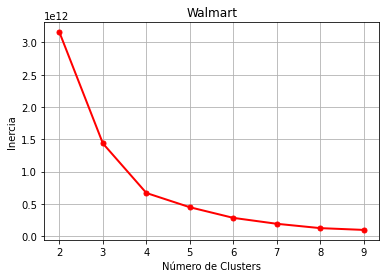

In [6]:
def plot_elbow_method(data, min_k, max_k, n_init, text_title) :
    inertia_clusters = []
    for k in range(min_k, max_k):
        kmeans = KMeans(n_clusters = k, 
                        n_init = n_init)
        kmeans.fit(data)
        
        inertia_clusters.append([k, kmeans.inertia_])
    
    x, y = zip(*[inertia for inertia in inertia_clusters])
    plt.plot(x, y, 'ro-', markersize=5, lw=2)
    plt.xticks(range(min_k, max_k))
    plt.grid(True)
    plt.xlabel('Número de Clusters')
    plt.ylabel('Inercia')
    plt.title(text_title)
    plt.show()

plot_elbow_method(df2, 2, 10, 10, "Walmart")

Elegimos como número de clúster: 4

In [7]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

km = KMeans(n_clusters = 4,
            random_state = 1).fit_predict(df2)

ac = AgglomerativeClustering(n_clusters = 4, 
                             affinity = 'euclidean',
                             linkage = 'complete').fit_predict(df2)

db = DBSCAN(eps = 100000,
            min_samples = 5,
            metric = 'euclidean').fit_predict(df2)

In [8]:
f1 = df2['Store']
f2 = df2['TotalSalesWeek']

In [9]:
colormap = np.array(km)
colormap2 = np.array(ac)
colormap3 = np.array(db)

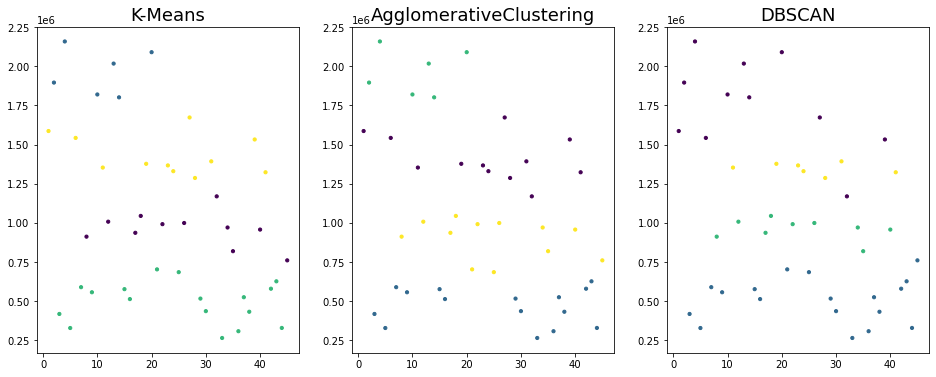

In [10]:
figure(figsize=(16, 6))
subplot(1, 3, 1)
plt.title('K-Means', size=18)
scatter(f1,f2, s=10, c = colormap)
subplot(1, 3, 2)
plt.title('AgglomerativeClustering', size=18)
scatter(f1,f2, s=10, c = colormap2)
subplot(1, 3, 3)
plt.title('DBSCAN', size=18)
scatter(f1,f2, s=10, c = colormap3)

A continuación se comparan los 3 métodos aplicando el Dunn Index

In [17]:
def normalize_to_smallest_integers(labels):
    max_v = len(set(labels)) if -1 not in labels else len(set(labels)) - 1
    sorted_labels = np.sort(np.unique(labels))
    unique_labels = range(max_v)
    new_c = np.zeros(len(labels), dtype=np.int32)

    for i, clust in enumerate(sorted_labels):
        new_c[labels == clust] = unique_labels[i-1]

    return new_c




def min_cluster_distances(labels, distances):
    labels = normalize_to_smallest_integers(labels)
    n_unique_labels = len(np.unique(labels))

    min_distances = np.full((n_unique_labels, n_unique_labels), np.inf)
    for i in np.arange(0, len(labels) - 1):
        for ii in np.arange(i + 1, len(labels)):
            if labels[i] != labels[ii] and distances[i, ii] < min_distances[labels[i], labels[ii]]:
                min_distances[labels[i], labels[ii]] = min_distances[labels[ii], labels[i]] = distances[i, ii]
    return min_distances



def diameter(labels, distances):
    labels = normalize_to_smallest_integers(labels)
    n_clusters = len(np.unique(labels))
    diameters = np.zeros(n_clusters)

    for i in np.arange(0, len(labels) - 1):
        for ii in np.arange(i + 1, len(labels)):
            if labels[i] == labels[ii] and distances[i, ii] > diameters[labels[i]]:
                diameters[labels[i]] = distances[i, ii]
    return diameters

def dunn(labels, distances):
    labels = normalize_to_smallest_integers(labels)

    unique_cluster_distances = np.unique(min_cluster_distances(labels, distances))
    max_diameter = max(diameter(labels, distances))

    if np.size(unique_cluster_distances) > 1:
        return unique_cluster_distances[1] / max_diameter
    else:
        return unique_cluster_distances[0] / max_diameter
    


In [18]:
Dunn_Index = pd.DataFrame(np.array([[dunn(km, euclidean_distances(np.array(df2))), 
                                             dunn(ac, euclidean_distances(np.array(df2))),
                                            dunn(db, euclidean_distances(np.array(df2)))]]), 
                                  columns = ['K-Means', 'Agglomerative Clustering', 'DBSCAN'])

In [13]:
Dunn_Index

,K-Means,Agglomerative Clustering,DBSCAN
0,0.268249,0.247808,0.126201


Los algoritmos que producen grupos con altos índices de Dunn son más deseables, por lo que se continuará la segmentación de tiendas utilizando K-Means

In [14]:
kmeans = KMeans(n_clusters = 4, n_init = 300).fit(df2)
kmeans.cluster_centers_

array([[1.05000000e+01, 1.96308677e+06],
       [2.54705882e+01, 4.94299851e+05],
       [2.27272727e+01, 1.43293736e+06],
       [2.62727273e+01, 9.61028955e+05]])

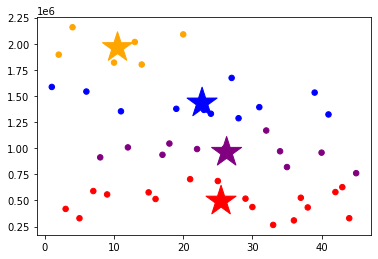

In [15]:
kmeans = KMeans(n_clusters=4).fit(df2)
C = kmeans.cluster_centers_
labels = kmeans.predict(df2)
colores=['red','blue','purple','orange']
asignar=[]
for row in labels:
    asignar.append(colores[row])

plt.scatter(f1, f2, c=asignar, s=30)
plt.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=1000)
plt.show()

In [16]:
labels = kmeans.predict(df2)

for i in range(max(labels) + 1):
    print ("Cluster", i)
    print (unique(df2["Store"][labels == i]))
    print ("Media de ventas: ", round(mean(df2["TotalSalesWeek"][labels==i])))

Cluster 0
[ 3  5  7  9 15 16 21 25 29 30 33 36 37 38 42 43 44]
Media de ventas:  494300
Cluster 1
[ 1  6 11 19 23 24 27 28 31 39 41]
Media de ventas:  1432937
Cluster 2
[ 8 12 17 18 22 26 32 34 35 40 45]
Media de ventas:  961029
Cluster 3
[ 2  4 10 13 14 20]
Media de ventas:  1963087
